In [52]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import sys
import math
from numpy import genfromtxt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu
%matplotlib inline

In [71]:
# MIXED
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926# 0.94810295#

# load and process pion file
pi0_file_num = 16
pipm1_file_num = 14
pipm2_file_num = 15
len_file = 6000
i_low = 10
i_high = 19
energy_threshold = 0
BATCH_SIZE = 100
group_events = True
mixed = True
cut = False
rho = False
new_format = False
include_tracks = True
left_from_include_tracks = False
pion_dir = "/fast_scratch_1/jbohm/train_testing_data/" + ("charged_" if not mixed else "") + "pion_files"


In [92]:
#CHARGED
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926# 0.94810295#

# load and process pion file
pi0_file_num = 16
pipm1_file_num = 14
pipm2_file_num = 15
len_file = 6000
i_low = 20
i_high = 29
energy_threshold = 0
BATCH_SIZE = 100
group_events = True
mixed = False
rho = False
cut = False
new_format = False
include_tracks = False
left_from_include_tracks = True
pion_dir = "/fast_scratch_1/jbohm/train_testing_data/" + ("charged_" if not mixed else "") + "pion_files"


In [61]:
# CHARGED SMALLER TEST - for track data
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
LOG_MEAN_TRACK_MOMETUM = 4
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926# 0.94810295#

# load and process pion file
pi0_file_num = 0
pipm1_file_num = 17
pipm2_file_num = 0
len_file = 6000
i_low = 0
i_high = 4
energy_threshold = 0
BATCH_SIZE = 75
group_events = True
mixed = False
rho = False
cut = False
new_format = True
include_tracks = True
left_from_include_tracks = False
pion_dir = "/fast_scratch_1/jbohm/cell_em_frac_learning/" + ("charged_" if not mixed else "") + "pion_files"

Load preds and labels

In [139]:
#model_file_path = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_tracks_cor/pnet_charged_events_1_track_add_min_dist_and_energy_ratio_tr_650_val_198_tst_10_lr_1e-2_masked_BN"
#epoch = 13 # start at 0

#model_file_path = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_tracks_cor/pnet2_charged_events_all_one_track_tr_650_val_10_npoints_75_50_tracks_4_r_0.2_0.4_0.1_0.2"
model_file_path = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/tr_50_val_5_tst_5_lr_1e-2_BS_100_no_tnets"
epoch = 6 # start at 0

num_epochs = epoch + 1

if mixed:
    labels_unmasked = np.load(model_file_path + "/tests/mixed_labels.npy") 
    preds_unmasked = np.load(model_file_path + "/tests/mixed_large_trackless_dist_1e5_preds_" + str(epoch) + ".npy") 
elif not rho:
    labels_unmasked = np.load(model_file_path + "/tests/labels.npy") 
    preds_unmasked = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")
else:
    labels_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/rho_analysis/rho_small_preds.npy")
    preds_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/rho_analysis/rho_small_preds.npy")

#labels_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_evaluate_tracks/test_1_track_labels.npy")
#preds_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_evaluate_tracks/pnet_charged_events_1_track_add_min_dist_and_energy_ratio_tr_650_val_198_tst_10_lr_1e-2_masked_BN_test_1_track_preds_12.npy")
# cut out all events where the truth cell classifications are all the same class
if cut:
    keep_events = np.array([np.sum(event_labels[event_labels != -1]) != 0 and np.sum(event_labels[event_labels != -1]) != len(event_labels[event_labels != -1]) for event_labels in labels_unmasked])
    preds_unmasked = preds_unmasked[keep_events]
    labels_unmasked = labels_unmasked[keep_events]

    print(len(preds_unmasked))
    print(len(preds_unmasked[0]))

#preds_unmasked = preds_unmasked[:, :1615, :]
#labels_unmasked = labels_unmasked[:, :1615, :]
preds = preds_unmasked[labels_unmasked != -1]
labels = labels_unmasked[labels_unmasked != -1]


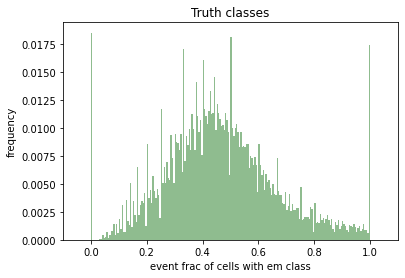

In [56]:
#model_dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_charged_events_thresh_0.787_tr_312_val_78_tst_10_lr_1e-6' # best charged trained so far
#labels_unmasked = np.load(model_file_path + "/tests/cut_1_labels.npy") 

clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels_unmasked])
pu.plot_hist(clus_frac_em_class, 200, "Truth classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))


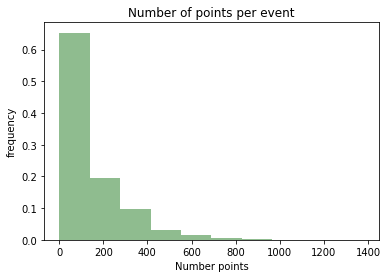

mean num points: 137.674237065481


In [13]:
num_points = [np.sum([len(clus_em_frac_class) for clus_em_frac_class in event_em_frac_class]) for event_em_frac_class in processed_event_data["truth_EM_frac_class"]]
pu.plot_hist(num_points, 10, "Number of points per event", "Number points", "frequency", True, "darkseagreen")
print("mean num points:", np.mean(num_points))

Load pion data from root converted to npy files

In [58]:
# track metadata
calo_layers = ['EMB1', 'EMB2', 'EMB3', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1',
    'HEC2', 'HEC3', 'TileBar0', 'TileBar1', 'TileBar2', 'TileGap1', 'TileGap2',
    'TileGap3', 'TileExt0', 'TileExt1', 'TileExt2']

NUM_TRACK_POINTS = len(calo_layers)

has_fixed_r = {
    'EMB1': True,
    'EMB2': True,
    'EMB3': True,
    'EME1': False,
    'EME2': False,
    'EME3': False,
    'HEC0': False,
    'HEC1': False,
    'HEC2': False,
    'HEC3': False,
    'TileBar0': True,
    'TileBar1': True,
    'TileBar2': True,
    'TileGap1': True,
    'TileGap2': True,
    'TileGap3': True,
    'TileExt0': True,
    'TileExt1': True,
    'TileExt2': True
}

fixed_r = {
    'EMB1': 1532.18,
    'EMB2': 1723.89,
    'EMB3': 1923.02,
    'TileBar0': 2450.00,
    'TileBar1': 2995.00,
    'TileBar2': 3630.00,
    'TileGap1': 3215.00,
    'TileGap2': 3630.00,
    'TileGap3': 2246.50,
    'TileExt0': 2450.00,
    'TileExt1': 2870.00,
    'TileExt2': 3480.00
}

fixed_z = {
    'EME1': 3790.03,
    'EME2': 3983.68,
    'EME3': 4195.84,
    'HEC0': 4461.25,
    'HEC1': 4869.50,
    'HEC2': 5424.50,
    'HEC3': 5905.00,
}

In [64]:
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)


print("mixed:", mixed)
# load cell geo tree dict
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'

if mixed:
    file_names = ["/pi0_" + str(pi0_file_num) + "_pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]
elif rho:
    file_names = ["one file"]
elif new_format:
    file_names = list(map(lambda i:  "/pipm_" + str(pipm1_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1)))
else:
    file_names = ["/pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_" + str(pi0_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]

print(file_names)
cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}


cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_E', 'cluster_Pt', 'nTracks']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P']:
    processed_event_track_data[feature] = []

samples_count = 0

tot_event = 0
for file_name in file_names:
    if rho:
        event_data = uproot.open("/data/atlas/data/rho_delta/rho_small.root:EventTree").arrays(library="np")
    else:
        event_data = np.load(pion_dir + file_name, allow_pickle=True).item()

    num_events = len(event_data["eventNumber"])
    num_cells = 0

    for event_idx in range(num_events):
        print(event_idx)
        num_clusters = event_data["nCluster"][event_idx]
        num_tracks = event_data["nTrack"][event_idx]
        if num_clusters != 0:
            processed_event_data['nTracks'].append(num_tracks)

        if (left_from_include_tracks and num_tracks != 1) or (not include_tracks and not left_from_include_tracks) or (include_tracks and num_tracks == 1):
            if include_tracks:
                if num_tracks == 1:
                    # get track info
                    # considering 6 track hits, one in each section of calorimeter
                    etas = []
                    phis = []
                    rPerps = []
                    # get the eta, phi, and rPerp of each layers hit
                    for layer_name in calo_layers:
                        if has_fixed_r[layer_name]:
                            etas.append(event_data['trackEta_' + layer_name][event_idx][0])
                            phis.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            rPerps.append(fixed_r[layer_name])
                        else:
                            eta = event_data['trackEta_' + layer_name][event_idx][0]
                            etas.append(eta)
                            phis.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            
                            z = fixed_z[layer_name]
                            aeta = np.abs(eta)
                            rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                            rPerps.append(rPerp)
                    
                    # convert each hit to the cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
                    x_tracks, y_tracks, z_tracks = spherical_to_cartesian(rPerps, phis, thetas)

                    non_null_tracks = np.full(NUM_TRACK_POINTS, True)

                    # if eta > 4.9 or phi > pi mark the track as null (why??)
                    non_null_tracks[(np.abs(etas) >= 2.5) | (np.abs(phis) > np.pi)] = False
                else:
                    non_null_tracks = np.full(NUM_TRACK_POINTS, 0)
                    x_tracks, y_tracks, z_tracks = np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS)

            # Only keep event if there is at least one track hit
            if not include_tracks or np.count_nonzero(non_null_tracks) != 0:
                for cluster_idx in range(num_clusters):
                    cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

                    # get truth enery (EM/nonEM)
                    cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
                    cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
                    cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

                    # filter out cells with truth energy of 0
                    threshold_E = cell_hits_E > energy_threshold
                    
                    cell_IDs = cell_IDs[threshold_E]
                    num_cells_in_clus = len(cell_IDs)
                    num_cells += num_cells_in_clus
                    cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

                    # get truth energy fraction EM/EM + nonEM for each cell
                    truth_EM_frac = cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E]

                    # classify truth_EM_frac
                    truth_EM_frac_class = [0 if truth_EM_frac_i <= THRESHOLD_EM_FRAC else 1 for truth_EM_frac_i in truth_EM_frac] # YES it is classifying the data !!! jus not naming the files - classify

                    # get cluster cell energy
                    cluster_cell_E = event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E]

                    # node features
                    node_features = {}
                    for feature in node_feature_names:
                        node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

                    # get cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
                    x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

                    # get target particle - 0 for pi0 [111], 1 for pi+/- [-111]
                    truth_particle = 0 if event_data["truthPartPdgId"][event_idx][0] == 111 else 1

                    cluster_Pt = event_data["cluster_Pt"][event_idx][cluster_idx]
                    cluster_E = event_data["cluster_E"][event_idx][cluster_idx]

                    # if grouped by events extend the set of event points with the clusters points
                    if group_events and num_cells_in_clus != 0:
                        # append empty array for all cells in an event
                        if len(processed_event_data["cluster_cell_E"]) == samples_count:
                            for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_Pt', 'cluster_E']:
                                processed_event_data[feature].append([])

                        processed_event_data["truth_EM_frac"][samples_count].append(truth_EM_frac)
                        processed_event_data["truth_EM_frac_class"][samples_count].append(truth_EM_frac_class)
                        processed_event_data["cluster_cell_E"][samples_count].append(cluster_cell_E)
                        processed_event_data["truth_particle"][samples_count].append(truth_particle)
                        processed_event_data["cluster_Pt"][samples_count].append(cluster_Pt)
                        processed_event_data["cluster_E"][samples_count].append(cluster_E)


                        for feature in node_feature_names:
                            processed_event_data[feature][samples_count].append(node_features[feature])

                        processed_event_data["x"][samples_count].append(x)
                        processed_event_data["y"][samples_count].append(y)
                        processed_event_data["z"][samples_count].append(z)

                    # if grouped by clusters append the set of clusters points
                    elif num_cells_in_clus != 0: # not used for analysis yet - update later
                        processed_event_data["truth_EM_frac"].append(truth_EM_frac)
                        processed_event_data["truth_EM_frac_class"].append(truth_EM_frac_class)
                        processed_event_data["cluster_cell_E"].append(cluster_cell_E)
                        processed_event_data["truth_particle"].append(truth_particle)

                        for feature in node_feature_names:
                            processed_event_data[feature].append(node_features[feature])

                        processed_event_data["x"].append(x)
                        processed_event_data["y"].append(y)
                        processed_event_data["z"].append(z)
                        
                        samples_count += 1
                        num_cells = 0
                    
                if group_events and num_cells > 0:      
                    if include_tracks:            
                        if num_tracks == 1:
                            # get tracks momentum readout
                            trackP = np.log10(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                            num_tracks = np.sum(non_null_tracks)
                            trackPs = np.full(NUM_TRACK_POINTS, trackP)
                        else:
                            trackPs = np.full(NUM_TRACK_POINTS, 0)
                        
                        # zero out all values in null tracks
                        x_tracks[~non_null_tracks] = 0
                        y_tracks[~non_null_tracks] = 0
                        z_tracks[~non_null_tracks] = 0
                        trackPs[~non_null_tracks] = 0

                        processed_event_track_data["x"].append(x_tracks)
                        processed_event_track_data["y"].append(y_tracks)
                        processed_event_track_data["z"].append(z_tracks)
                        processed_event_track_data["P"].append(trackPs)

                    # update event counter and max cells/event tracking
                    samples_count += 1
                    num_cells = 0
    
    if BATCH_SIZE:
        # filter to BS multiple num samples/files - to make set even with preds from a trained model
        BS_multiple_num_samples = math.floor(samples_count / BATCH_SIZE)*BATCH_SIZE
        print("BS_multiple_num_samples", BS_multiple_num_samples)
        print("samples_count", samples_count)
        if BS_multiple_num_samples == samples_count:
            BS_multiple_num_samples -= BATCH_SIZE
        for key in processed_event_data:
            del processed_event_data[key][BS_multiple_num_samples - samples_count:]
        print("num dropped events:", samples_count - BS_multiple_num_samples)
        samples_count = BS_multiple_num_samples
    
    print("num events in file:", samples_count)


if cut:
    print("start cut")
    dropped_events = 0
    for i, keep_event in enumerate(keep_events):
        if not keep_event:
            for key in processed_event_data:
                del processed_event_data[key][i + dropped_events]
            dropped_events -= 1
    

mixed: False
['/pipm_17_len_6000_i_0.npy', '/pipm_17_len_6000_i_1.npy', '/pipm_17_len_6000_i_2.npy', '/pipm_17_len_6000_i_3.npy', '/pipm_17_len_6000_i_4.npy']
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237

/tmp/ipykernel_55370/1137956549.py:87: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_55370/1137956549.py:87: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_55370/1137956549.py:91: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]


243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492


KeyboardInterrupt: 

New mixed dataset separation anlysis

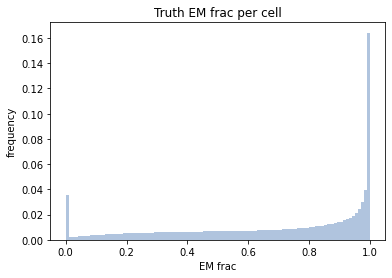

0.7786367


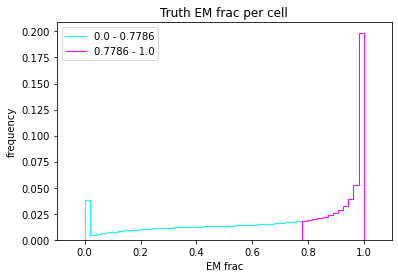

In [114]:
# plot hist of cellwise truth EM frac
colours = ["cyan", "fuchsia"]
truth_EM_frac_cellwise = flatten_events_to_cells(processed_event_data["truth_EM_frac"])
pu.plot_hist(truth_EM_frac_cellwise, 100, "Truth EM frac per cell", "EM frac", "frequency", colour="lightsteelblue")

# split array into N equal parts
num_class = 2
truth_EM_frac_cellwise_sort = np.sort(truth_EM_frac_cellwise)
truth_EM_frac_cellwise_split = np.array_split(truth_EM_frac_cellwise_sort, num_class)
print(np.max(truth_EM_frac_cellwise_split[0]))

labels = np.arange(num_class)
fig = plt.figure()
fig.patch.set_facecolor('white')

all_data_counts, all_data_bins = np.histogram(truth_EM_frac_cellwise_split)
for i, data in enumerate(truth_EM_frac_cellwise_split):
    bins = math.ceil((np.max(data) - np.min(data))*50)
    counts, bins = np.histogram(data, bins)
    counts = counts / np.sum(all_data_counts)
    # normalize counts
    plt.stairs(counts, bins, label=str(np.round(np.min(data), 4)) + " - " + str(np.round(np.max(data), 4)), color=colours[i])

plt.title("Truth EM frac per cell")
plt.xlabel("EM frac")
plt.ylabel("frequency")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()



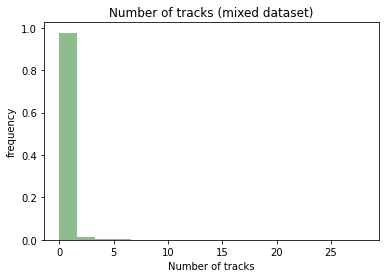

zero tracks: 0.20215383070589416
one track: 0.774575760618536
2+ tracks: 0.023270408675569836


In [77]:
# get track info of processed dataset
pu.plot_hist(processed_event_data['nTracks'], 17, "Number of tracks (mixed dataset)", "Number of tracks", "frequency", colour="darkseagreen")

print("zero tracks:", len(np.array(processed_event_data["nTracks"])[np.array(processed_event_data["nTracks"]) == 0]) / len(processed_event_data["nTracks"]))
print("one track:", len(np.array(processed_event_data["nTracks"])[np.array(processed_event_data["nTracks"]) == 1]) / len(processed_event_data["nTracks"]))
print("2+ tracks:", len(np.array(processed_event_data["nTracks"])[np.array(processed_event_data["nTracks"]) >= 2]) / len(processed_event_data["nTracks"]))


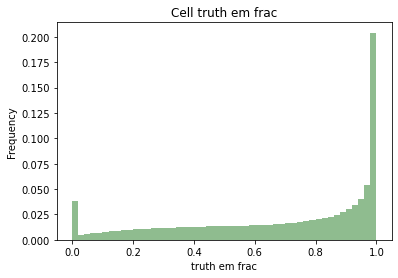

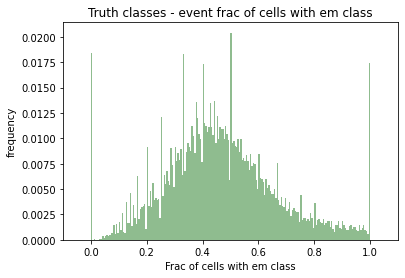

In [78]:
# plot em frac distribution
pu.plot_hist(flatten_events_to_cells(processed_event_data["truth_EM_frac"]), 50, "Cell truth em frac", "truth em frac", "Frequency", colour="darkseagreen")

# plot frac cells classified as high em frac distribution
event_frac_cells_em_class = np.array([np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])])
pu.plot_hist(event_frac_cells_em_class, 200, "Truth classes - event frac of cells with em class", "Frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))


Test data load

In [314]:
# TEST DATA LOAD
print("num events", preds_unmasked.shape[0])
print("num loaded events:", len(processed_event_data["x"]))

print("num cells em class", np.sum(flatten_events_to_cells(processed_event_data["truth_EM_frac_class"])))
print("num cells em class (loaded events):", np.sum(labels[labels != -1]))

num events 15150
num loaded events: 15150
num cells em class 1155785
num cells em class (loaded events): 1155785.0


Train analysis functions

In [327]:
# event/cluster/cell flattening functions
def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

# train loss/acc analysis plots
def get_accuracy(preds, labels):
    correct = []
    for i, pred in enumerate(preds):
        acc = (pred <= 0.5)*(1 - labels[i]) + (pred > 0.5)*labels[i]
        correct.append(acc)
    return sum(correct) / len(correct) 

def get_masked_pointwise_bce(preds, labels):
    epsilon = 1e-7#np.exp(-20)
    bce = -(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

def get_masked_weighted_pointwise_bce(preds, truth):
    labels = np.expand_dims(truth[:, :, 0], -1)
    weights = np.expand_dims(truth[:, :, 1], -1)
    unmasked = labels != MASK_OUT
    epsilon = 1e-7#np.exp(-20)
    preds = preds[unmasked]
    labels = labels[unmasked]
    weights = weights[unmasked]
    bce = -weights*(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

# plot train and val loss over epoch
def plot_train_and_val_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def plot_train_and_val_acc(train_acc, val_acc):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_acc, label="train")
    plt.plot(val_acc, label="val")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def plot_accuracy(preds, labels):
    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy(epoch_preds, labels))
    print("accuracy:", accuracy)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()

def plot_test_loss(preds, labels):
    test_loss = []
    for epoch_preds in preds:
        test_loss.append(np.mean(get_masked_pointwise_bce(epoch_preds, labels)))
    print("test loss:", test_loss)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(test_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

def plot_event_frac_em_class(preds_unmasked, labels_unmasked):
    frac_events_all_low_em_class = []
    frac_events_all_high_em_class = []
    for epoch_preds in preds_unmasked:
        pred_em_frac = np.array([np.sum([pred > 0.5 for pred in epoch_preds[i][event_labels != -1]]) / len(event_labels[event_labels != -1]) for i, event_labels in enumerate(labels_unmasked)])
        frac_events_all_low_em_class.append(len(pred_em_frac[pred_em_frac == 0]) / len(pred_em_frac))
        frac_events_all_high_em_class.append(len(pred_em_frac[pred_em_frac == 1]) / len(pred_em_frac))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(frac_events_all_low_em_class, label="All low em class", color="darkseagreen")
    plt.plot(frac_events_all_high_em_class, label="All high em class", color="orchid")
    plt.plot(np.array(frac_events_all_low_em_class) + np.array(frac_events_all_high_em_class), color="grey")
    plt.xlabel("epoch")
    plt.ylabel("Frac events with all cells pred same class")
    plt.legend()
    plt.show()

def train_summary_stats(model_file_path, num_epochs, load_acc=False):
    # load all train data
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]
    plot_train_and_val_loss(loss, val_loss)

    if load_acc:
        acc_data = genfromtxt(model_file_path + "/log_accuracy.csv", delimiter=',').transpose()
        acc = acc_data[1]
        val_acc = acc_data[2]
        plot_train_and_val_acc(acc, val_acc)
    
    labels_unmasked = np.load(model_file_path + "/tests/labels.npy")
    #labels_unmasked = labels_unmasked[:, :1615, :]
    preds_unmasked = []
    preds = []
    for epoch in range(num_epochs):
        epoch_preds = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")
        #epoch_preds = epoch_preds[:, :1615, :] # temp cut
        preds_unmasked.append(epoch_preds)
        preds.append(epoch_preds[labels_unmasked != -1])
    labels = labels_unmasked[labels_unmasked != -1]

    if not load_acc:
        plot_test_loss(preds, labels)
        plot_accuracy(preds, labels)
    plot_event_frac_em_class(preds_unmasked, labels_unmasked)

def get_cut_count(EM_frac, p_yi, cut_EM_frac_low, cut_EM_frac_high, cut_p_yi_low, cut_p_yi_high):
    EM_frac = np.array(EM_frac)
    p_yi = np.array(p_yi)
    point_cut = (EM_frac >= cut_EM_frac_low) & (EM_frac < cut_EM_frac_high) & (p_yi >= cut_p_yi_low) & (p_yi < cut_p_yi_high)
    return len(EM_frac[point_cut])

def plot_em_frac_vs_preds(em_frac, preds, title="All cells", bins=(50,50)):
    print(len(em_frac))
    print(len(preds))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(em_frac, preds, bins, cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())

    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')
    
    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("EM frac")
    plt.ylabel("P(EM frac >= " + str(THRESHOLD_EM_FRAC) + ")")
    plt.title("All cells")
    plt.show()

def plot_em_frac_vs_preds_normalize_col(em_frac, preds, title="All cells", bins=(50,50)):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    hist, xedges, yedges = np.histogram2d(em_frac, preds, bins, range=((0,1), (0,1)))
    for i in range(hist.shape[0]):
        hist[i, :] = hist[i, :] / np.sum(hist[i, :])

    plt.plot(x,y,'wo',alpha=0.3)
    plt.imshow(hist.T, 
               extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()],
               origin='lower', 
               interpolation='nearest', 
               cmap=plt.cm.terrain_r,
               vmin=0,
               vmax=1,
               aspect='auto')
    
    #plt.imshow(hist, cmap=plt.cm.magma)
    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')

    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("EM frac")
    plt.ylabel("P(EM frac >= " + str(THRESHOLD_EM_FRAC) + ")")
    plt.title(title)
    plt.show()

def plot_preds_hist_cut_em_frac(preds, em_frac, em_frac_low, em_frac_high, bins=50):
    em_frac = np.array(em_frac)
    em_frac_cut = (em_frac >= em_frac_low) & (em_frac < em_frac_high)
    pu.plot_hist(preds[em_frac_cut], bins, str(round(em_frac_low, 3)) + " <= truth em frac < " + str(round(em_frac_high, 3)), "P(EM frac >= 0.9481)", "frequency", colour="darkseagreen")
    
def plot_accuracy_over_em_cut(preds, labels, em_frac, num_points):
    em_frac = np.array(em_frac)
    accuracy = []

    for i in range(num_points):
        em_frac_cut = (em_frac >= i*(1/num_points)) & (em_frac < (i+1)*(1/num_points))
        accuracy.append(get_accuracy(preds[em_frac_cut], labels[em_frac_cut]))
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(1/num_points, 1 + (1/num_points), 1/num_points), accuracy, color="mediumorchid")
    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey', linewidth='0.5')
    plt.xlabel("EM frac")
    plt.ylabel("Accuracy")
    plt.title("Truth EM frac vs classification accuracy")
    plt.xlim((-0.1, 1.1))
    plt.show()


def plot_quadrent_info(preds, em_frac, bin_size=50):
    # if plotting p(yi) output accuracy for each quandrant
    bin_size = 1 / bin_size

    plt.rcParams["figure.figsize"] = [4, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    # count freq at in quadrant
    print("quadrants")
    bottom_left = get_cut_count(em_frac, preds, 0, THRESHOLD_EM_FRAC, 0, bin_size*25)
    top_left = get_cut_count(em_frac, preds, 0, THRESHOLD_EM_FRAC, bin_size*25, 1.1)
    bottom_right = get_cut_count(em_frac, preds, THRESHOLD_EM_FRAC, 1.1, 0, bin_size*25)
    top_right = get_cut_count(em_frac, preds, THRESHOLD_EM_FRAC, 1.1, bin_size*25, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    table = axs.table(cellText=[[round(top_left/len(em_frac), 4), round(top_right/len(em_frac), 4)], 
        [round(bottom_left/len(em_frac), 4), round(bottom_right/len(em_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    # count freq at corner points
    print("corners")
    point_0_0 = get_cut_count(em_frac, preds, 0, bin_size, 0, bin_size)
    point_0_1 = get_cut_count(em_frac, preds, 0, bin_size, 1 - bin_size, 1.1)
    point_1_0 = get_cut_count(em_frac, preds, 1 - bin_size, 1.1, 0, bin_size)
    point_1_1 =  get_cut_count(em_frac, preds, 1 - bin_size, 1.1, 1 - bin_size, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=[[round(point_0_1/len(em_frac), 4), round(point_1_1/len(em_frac), 4)],
        [round(point_0_0/len(em_frac), 4), round(point_1_0/len(em_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)

    # sum check
    #print("Total cells (len(em_frac)):", len(em_frac))
    #print("Total cells in quadrants:", bottom_left + top_left + bottom_right + top_right)

    # class accuracy
    #print("Left class accuracy [P(EM frac < 0.9481)]:", bottom_left / (bottom_left + top_left))
    #print("Right class accuracy [P(EM frac >= 0.9481)]:", top_right / (bottom_right + top_right))

def plot_cut_accuracies(preds, labels, em_frac):
    # get cuts
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    neutral_cut_cellwise = np.array(neutral_cut_cellwise)

    em_class_cut = (np.array(labels) == 1)

    em_frac_one = (em_frac == 1)

    accuracies = [["", "Had class", "EM class", "EM frac = 1", str(THRESHOLD_EM_FRAC) + " <= EM frac < 1", "Both classes"]]
    if mixed:
        accuracies.append(["Neutral", round(get_accuracy(preds[neutral_cut_cellwise & ~em_class_cut], labels[neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut], labels[neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_frac_one], labels[neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise], labels[neutral_cut_cellwise]), 3)])
        accuracies.append(["Charged", round(get_accuracy(preds[~neutral_cut_cellwise & ~em_class_cut], labels[~neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut], labels[~neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_frac_one], labels[~neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[~neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise], labels[~neutral_cut_cellwise]), 3)])
        
    accuracies.append(["Mixed", round(get_accuracy(preds[~em_class_cut], labels[~em_class_cut]), 3),
    round(get_accuracy(preds[em_class_cut], labels[em_class_cut]), 3),
    round(get_accuracy(preds[em_frac_one], labels[em_frac_one]), 3),
    round(get_accuracy(preds[em_class_cut & ~em_frac_one], labels[em_class_cut & ~em_frac_one]), 3),
    round(get_accuracy(preds, labels), 3)])
    
    if mixed:
        plt.rcParams["figure.figsize"] = [20, 2]
    else:
        plt.rcParams["figure.figsize"] = [20, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    print("accuracies:")
    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=accuracies, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)


def plot_filtered_em_frac_vs_preds(preds, em_frac, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        plot_em_frac_vs_preds(preds, em_frac, "All cells")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)

        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Neutral pions")
        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Charged pions")
    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        plot_em_frac_vs_preds(em_frac[em_cut_cellwise], preds[em_cut_cellwise], "EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_cellwise], preds[~em_cut_cellwise], "EM <= " + str(threshold))

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)

        plot_em_frac_vs_preds(em_frac[em_cut_clusterwise], preds[em_cut_clusterwise], "clus mean EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_clusterwise], preds[~em_cut_clusterwise], "clus mean EM <= " + str(threshold))


def plot_cellwise_hist(cellwise_data, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        pu.plot_hist(cellwise_data, 50, title, xlabel, "frequency")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)
        pu.plot_overlay_hist([cellwise_data[neutral_cut_cellwise], cellwise_data[~neutral_cut_cellwise]], bins, title, xlabel, "frequency", ["neutral", "charged"])

    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        pu.plot_overlay_hist([cellwise_data[em_cut_cellwise], cellwise_data[~em_cut_cellwise]], bins, title, xlabel, "frequency", ["EM > " + str(threshold), "EM <= " + str(threshold)])

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)
        pu.plot_overlay_hist([cellwise_data[em_cut_clusterwise], cellwise_data[~em_cut_clusterwise]], bins, title, xlabel, "frequency", ["clus mean EM > " + str(threshold), "clus mean EM <= " + str(threshold)])

def plot_roc(preds, labels):
    fp, tp, threshs = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    print('auc:', auc)

    # compute frac correct classifications for each threshold
    #corr = list(map(lambda thresh: accuracy_score(labels, list(map(lambda pred: pred > thresh, preds))), threshs))
    #print("max acc:", np.max(corr)) 

    # 1) basic roc
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(fp, tp, linewidth=0.25, color="lightsteelblue")
    plt.title('roc')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    # 2) signal efficiency vs 1/background efficiency (1/[1-fpr])
    invs_back_eff = np.log10(1 / fp[1:]) # first fp = 0

    # filter out all singal efficiencies < 0.6
    sig_effs = tp[1:]
    rejects = []
    #thresholds = []
    #for i, sig_eff in enumerate(tp):
    #    if sig_eff > 0.6:
    #        sig_effs.append(sig_eff)
    #        rejects.append(invs_back_eff[i])
    #        #thresholds.append(threshs[i])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(sig_effs, invs_back_eff, linewidth=0.25, color="lightsteelblue")#, c=thresholds)
    plt.title('roc')
    plt.xlabel('signal efficiency (TPR)')
    plt.ylabel('log10[1/(1 - background efficiency)] (1/FPR)')
    plt.show()

def plot_clus_em_frac_mean_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]


    clus_em_frac_mean = np.array([np.mean(clus_em_frac) for clus_em_frac in em_frac])[cut_clus]

    em_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) > THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]
    had_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) <= THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]


    pu.plot_hist(clus_em_frac_mean, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", True, "darkseagreen", (0,1))
    pu.plot_overlay_hist([em_class_clus_em_frac_mean, had_class_clus_em_frac_mean], bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", ["em class", "had class"], ["darkseagreen", "orchid"], (0,1))

def plot_clus_cell_em_frac_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, num_clus, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]
    
    
    colour_cycle = ["darkseagreen", "orchid", "lightsteelblue", "lightsalmon", "darkviolet", "darkcyan"]    

    i = 0
    clus_idx = 0
    clus_cell_em_frac = []
    labels = []
    colours = []

    while num_clus != 0:
        if cut_clus[clus_idx]:
            clus_cell_em_frac.append(em_frac[clus_idx])
            labels.append("cluster " + str(clus_idx))
            colours.append(colour_cycle[i])
            num_clus -= 1
            i += 1
        clus_idx += 1

    pu.plot_overlay_hist(clus_cell_em_frac, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity <= " + str(cut_class_similar_high), "cell em frac", "frequency", labels, colours, (0,1))

def plot_clus_similarity_distribution(preds, labels, bins):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_frac_pred_em_class = np.array([np.sum([pred > 0.5 for pred in preds[i][clus_labels != -1]]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])
    

    pu.plot_hist(clus_frac_em_class, 200, "Truth classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    pu.plot_hist(clus_frac_pred_em_class, 200, "Predicted classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))#, (np.min(clus_frac_pred_em_class), np.max(clus_frac_pred_em_class))))
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, clus_preds in enumerate(preds)])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("event frac of cells with em class")
    plt.ylabel("event mean accuracy")
    plt.title("All events")
    plt.show()

    if mixed:
        neutral_clus_cut =  np.array([clus_truth_particles[0] == 0 for clus_truth_particles in processed_event_data["truth_particle"]])
        pu.plot_overlay_hist([clus_frac_em_class[neutral_clus_cut], clus_frac_em_class[~neutral_clus_cut]], bins, "Truth classes", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
        pu.plot_overlay_hist([clus_frac_pred_em_class[neutral_clus_cut], clus_frac_pred_em_class[~neutral_clus_cut]], bins, "Predicted classes", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
        
        # plot for neutral
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.hist2d(clus_frac_em_class[neutral_clus_cut], clus_mean_acc[neutral_clus_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
        plt.colorbar(label="frequency")
        plt.xlabel("even frac of cells with em class")
        plt.ylabel("event mean accuracy")
        plt.title("Neutral events")
        plt.show()

        # plot for charged
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.hist2d(clus_frac_em_class[~neutral_clus_cut], clus_mean_acc[~neutral_clus_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
        plt.colorbar(label="frequency")
        plt.xlabel("event frac of cells with em class")
        plt.ylabel("event mean accuracy")
        plt.title("Charged events")
        plt.show()

def plot_clus_preds_similarity_distribution(preds, labels, bins):
    clus_frac_pred_em_class = np.array([np.sum(preds[i][clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])

    pu.plot_hist(clus_frac_pred_em_class, bins, "All events - predicted classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    
    if mixed:
        neutral_clus_cut =  np.array([clus_truth_particles[0] == 0 for clus_truth_particles in processed_event_data["truth_particle"]])
        pu.plot_overlay_hist([clus_frac_pred_em_class[neutral_clus_cut], clus_frac_pred_em_class[~neutral_clus_cut]], bins, "", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    #print("mean clus acc:", np.mean(clus_mean_acc))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_pred_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("event frac of cells with em class")
    plt.ylabel("event mean accuracy")
    plt.title("All events")
    plt.show()

def plot_clus_info_dist(preds, labels, clus_frac_em_class_cut_low, clus_frac_em_class_cut_high, clus_mean_acc_cut_low, clus_mean_acc_cut_high, bins=50, title=""):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    clus_num_cells = np.array([len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_cell_em_frac = np.array([np.mean(clus_truth_em_frac) for clus_truth_em_frac in processed_event_data["truth_EM_frac"]])

    clus_cut = (clus_frac_em_class_cut_low <= clus_frac_em_class) & (clus_frac_em_class < clus_frac_em_class_cut_high) & (clus_mean_acc_cut_low <= clus_mean_acc) & (clus_mean_acc < clus_mean_acc_cut_high)
    
    pu.plot_hist(clus_num_cells[clus_cut], bins, title, "num cells", "frequency", colour="darkseagreen")
    pu.plot_hist(clus_mean_cell_em_frac[clus_cut][clus_mean_cell_em_frac[clus_cut] >0.98], bins, title, "mean cell em frac", "frequency", colour="darkseagreen")

def get_neutral_cell_cut():
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    return np.array(neutral_cut_cellwise)

def get_baseline_accuracy():
    events_em_class_frac = [np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])]
    majority_class_frac = [max(event_em_class_frac, 1 - event_em_class_frac) for event_em_class_frac in events_em_class_frac]
    return np.mean(majority_class_frac)

def get_cross_plot_quadrent_info(preds, labels, num_idxs=5, num_bins=50, event_idx=0):
    em_frac = np.around(np.array([np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])]), 5)
    had_frac = np.around(1 - em_frac, 5)
    acc = np.around(np.array([get_accuracy(event_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, event_preds in enumerate(preds)]), 5)

    # debug a certain event
    """
    print("event:", event_idx)
    print("event acc:", acc[event_idx])
    print("event frac em class:", em_frac[event_idx])
    print("event frac had class:", had_frac[event_idx])
    
    print("in quad 2:", ((em_frac[event_idx] < 0.5) & (acc[event_idx] < em_frac[event_idx])) | ((em_frac[event_idx] >= 0.5) & (acc[event_idx] < had_frac[event_idx])))
    print("acc == 1 - em_frac:", acc[event_idx] == had_frac[event_idx])
    """

    num_events = len(em_frac)
    idxs = np.arange(num_events)
    quad_1 = ((em_frac < 0.5) & (acc > had_frac)) | ((em_frac >= 0.5) & (acc > em_frac))
    quad_2 = ((em_frac < 0.5) & (acc < em_frac)) | ((em_frac >= 0.5) & (acc < had_frac))
    quad_3 = (em_frac < 0.5) & (acc < had_frac) & (acc > em_frac)
    quad_4 = (em_frac > 0.5) & (acc < em_frac) & (acc > had_frac)

    line_1 = (em_frac < 0.5) & (acc == em_frac)
    line_2 = (em_frac < 0.5) & (acc == had_frac)
    line_3 = (em_frac > 0.5) & (acc == em_frac)
    line_4 = (em_frac > 0.5) & (acc == had_frac)

    bottom_left = (em_frac < 1/num_bins) & (acc == em_frac)
    top_left = (em_frac < 1/num_bins) & (acc == had_frac)
    bottom_right = (em_frac > (num_bins - 1)/num_bins) & (acc == had_frac)
    top_right = (em_frac > (num_bins - 1)/num_bins) & (acc == em_frac)

    mid_point = (em_frac == 0.5) & (acc == em_frac)

    cuts = [quad_1, quad_2, quad_3, quad_4, line_1, line_2, line_3, line_4, mid_point, bottom_left, top_left, bottom_right, top_right]
    cut_names = ["quad_1", "quad_2", "quad_3", "quad_4", "line_1", "line_2", "line_3", "line_4", "mid_point", "bottom_left", "top_left", "bottom_right", "top_right"]

    # print size of each cut - normalized to be frac of events
    sum_event_fracs = 0
    event_fracs = {}
    for i, cut in enumerate(cuts):
        event_frac = round(cut.sum()/num_events, 3)
        #print(cut_names[i] + ":", event_frac)
        if i < 9:
            sum_event_fracs += event_frac
        else:
            print(cut_names[i] + ":", event_frac)

        event_fracs[cut_names[i]] = event_frac
    print("sum of event fracs:", sum_event_fracs)

    # make table of event fracs
    plt.rcParams["figure.figsize"] = [4, 1.5]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    event_fracs_format = [[event_fracs["line_2"], event_fracs["quad_1"], event_fracs["line_3"]],
                          [event_fracs["quad_3"], event_fracs["mid_point"], event_fracs["quad_4"]],
                          [event_fracs["line_1"], event_fracs["quad_2"], event_fracs["line_4"]]]
    
    table = axs.table(cellText=event_fracs_format, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)
    print()

    pred_em_frac = np.array([np.sum([pred > 0.5 for pred in preds[i][clus_labels != -1]]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])
    print("% events all low em class:", round(len(pred_em_frac[pred_em_frac == 0]) / len(pred_em_frac), 5))
    print("% events all high em class:", round(len(pred_em_frac[pred_em_frac == 1]) / len(pred_em_frac), 5))
    print("% events falsey all low em class:", round(len(pred_em_frac[(pred_em_frac == 0) & (em_frac != 0)]) / len(pred_em_frac), 5))
    print("% events falsey all high em class:", round(len(pred_em_frac[(pred_em_frac == 1) & (em_frac != 1)]) / len(pred_em_frac), 5))

    # get num_idxs idxs of each cut
    x_plot_idxs_dict = {}
    for i, cut in enumerate(cuts):
        #print(cut_names[i] + ":", idxs[cut][:num_idxs])
        x_plot_idxs_dict[cut_names[i]] = idxs[cut]
    return x_plot_idxs_dict


Train analysis

2351718
2351718


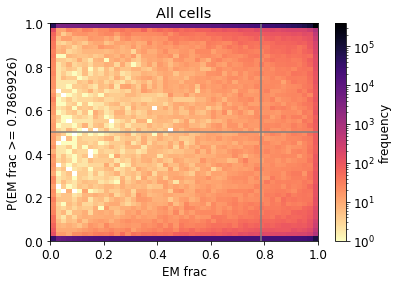

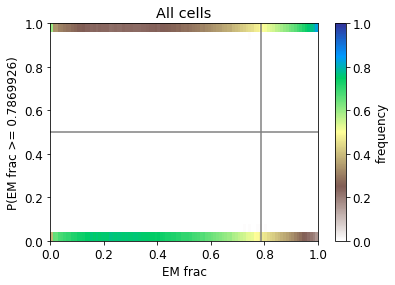

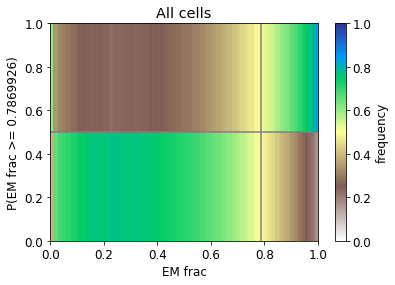

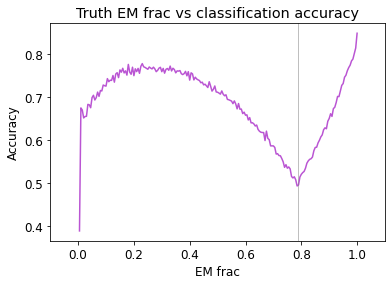

quadrants


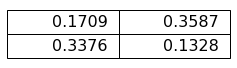

corners


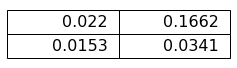

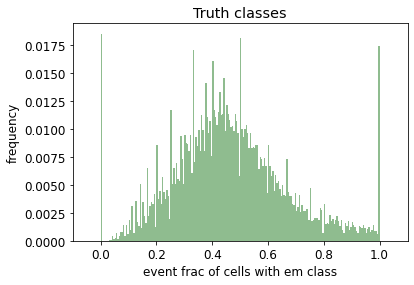

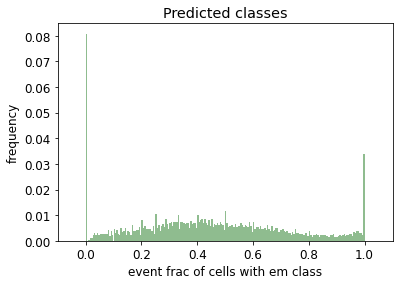

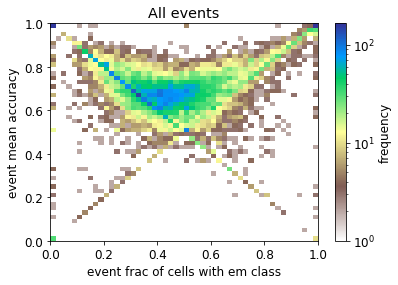

bottom_left: 0.002
top_left: 0.01
bottom_right: 0.001
top_right: 0.01
sum of event fracs: 0.999


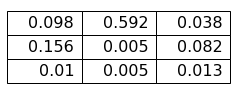


% events all low em class: 0.08079
% events all high em class: 0.0336
% events falsey all low em class: 0.07036
% events falsey all high em class: 0.02482
accuracies:


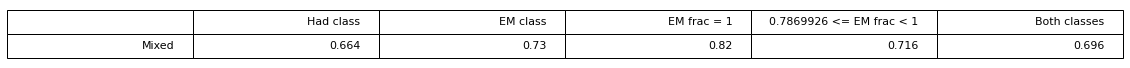

In [328]:
# plot train loss and accuracy summary over epoch
#train_summary_stats(model_file_path, num_epochs, load_acc=True)

# plot 2d hist of em frac vs predicted probability of high em class
em_frac = np.array(flatten_events_to_cells(processed_event_data["truth_EM_frac"]))

# plot em frac vs preds plots
plot_em_frac_vs_preds(em_frac, preds)
plot_em_frac_vs_preds_normalize_col(em_frac, preds, bins=(100, 25))
plot_em_frac_vs_preds_normalize_col(em_frac, preds, bins=(100,2))
# plot accuracy
plot_accuracy_over_em_cut(preds, labels, em_frac, 200)
plot_quadrent_info(preds, em_frac)
# plot event frac of cells with em class plots
plot_clus_similarity_distribution(preds_unmasked, labels_unmasked, 50)
x_plot_idxs_dict = get_cross_plot_quadrent_info(preds_unmasked, labels_unmasked)
plot_cut_accuracies(preds, labels, em_frac)

if mixed:
    print("baseline accuracy:", get_baseline_accuracy())

Event info histograms - cut by num clus, energy, pT

In [ ]:
# Plot event info histrograms
def get_weights(type, num_cells):
    if type == "slope_1":
        weights = np.array(list(range(num_cells, 0, -1)))
    return weights

def plot_event_clus_info_grouped(sort_by_data, group_by, num_clus=3, cuts_param=[], num_groups=0, bins=50, cut_particle=False):
    clus_mean_em_frac = []
    clus_mean_em_frac_weighted = []-
    for event_idx, event_truth_em_frac in enumerate(processed_event_data["truth_EM_frac"]):
        clus_mean_em_frac.append([])
        clus_mean_em_frac_weighted.append([])
        for cluster_idx, clus_truth_em_frac in enumerate(event_truth_em_frac):
            clus_mean_em_frac[event_idx].append(np.average(clus_truth_em_frac))
            clus_mean_em_frac_weighted[event_idx].append(np.average(clus_truth_em_frac, weights=processed_event_data["cluster_cell_E"][event_idx][cluster_idx]))

    clus_frac_em_class = []
    for event_idx, event_truth_em_frac_class in enumerate(processed_event_data["truth_EM_frac_class"]):
        clus_frac_em_class.append([])
        for clus_truth_em_frac_class in event_truth_em_frac_class:
            clus_frac_em_class[event_idx].append(np.sum(clus_truth_em_frac_class) / len(clus_truth_em_frac_class))

    # override with predicted clus_frac_cells_em_class
    """
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'
    epoch = 3 # start at 0
    preds = (np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))

    reshape_preds = []
    for event_idx, event_preds in enumerate(preds):
        preds_event_idx = 0
        reshape_preds.append([])
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_preds[event_idx].append(event_preds[preds_event_idx:preds_event_idx + len(clus_truth_em_class)])
            preds_event_idx += len(clus_truth_em_class)

    clus_frac_em_class = []
    for event_idx, event_truth_em_frac_class in enumerate(reshape_preds):
        clus_frac_em_class.append([])
        for clus_truth_em_frac_class in event_truth_em_frac_class:
            clus_frac_em_class[event_idx].append(np.sum(clus_truth_em_frac_class) / len(clus_truth_em_frac_class))
    """
    events_cut = [len(event_truth_em_frac) == num_clus for event_truth_em_frac in processed_event_data["truth_EM_frac"]]
    cut_idx = np.arange(len(processed_event_data["truth_EM_frac"]))[events_cut]
    clus_mean_em_frac_sorted_T = np.transpose([np.sort(clus_mean_em_frac_clus_i) for clus_mean_em_frac_clus_i in np.array(clus_mean_em_frac)[events_cut]])
    clus_mean_em_frac_weighted_sorted_T = np.transpose([np.sort(clus_mean_em_frac_clus_i) for clus_mean_em_frac_clus_i in np.array(clus_mean_em_frac_weighted)[events_cut]])
    clus_frac_em_class_sorted_T = np.transpose([np.sort(clus_frac_em_class_clus_i) for clus_frac_em_class_clus_i in np.array(clus_frac_em_class)[events_cut]])

    labels = ["low", "medium", "high", "higher", "even higher", "highest"]
    colours = ["darkseagreen", "orchid", "lightsteelblue", "pink", "salmon", "darkcyan"]

    # uncut
    pu.plot_overlay_hist(clus_mean_em_frac_sorted_T, bins, "Event clusters mean truth EM frac", "Clus mean EM frac", "Frequency", labels, colours, None, "upper left")
    pu.plot_overlay_hist(clus_mean_em_frac_weighted_sorted_T, bins, "Event clusters weighted mean truth EM frac", "Clus weighted mean EM frac", "Frequency", labels, colours, None, "upper left")
    pu.plot_overlay_hist(clus_frac_em_class_sorted_T, bins, "Event clusters frac cells with EM class", "Clus frac cells with EM class", "Frequency", labels, colours, None, "upper left")

    sort_by_data = sort_by_data[events_cut]
    if num_groups != 0:
        # compute cuts
        sorted_idx_array = np.argsort(sort_by_data)
        cuts = np.full((num_groups, len(sort_by_data)), False)
        sorted_idx_array_split = np.array_split(sorted_idx_array, num_groups)
        for i in range(num_groups):
            cuts[i][sorted_idx_array_split[i]] = True
        pu.plot_overlay_hist([np.array(sort_by_data)[cut] for cut in cuts], bins, "Split " + group_by,  group_by + " (GeV)", "frequency", [str(i) for i, cut in enumerate(cuts)], colours, (0, np.max(sort_by_data)))
        
        for i, cut_energy in enumerate(cuts):
            title = str(0 if i == 0 else round(sort_by_data[sorted_idx_array_split[i-1][-1]], 3)) + " <= " + group_by + " (GeV) < " + str(round(sort_by_data[sorted_idx_array_split[i][-1]], 3))
            

            if cut_particle == True:
                neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])[events_cut] # truth_part_list holds for each clus in event but all from same truth part
                
                # find which event lowest em class frac occurs in
                odd = (neutral_cut & cut_energy & np.array(clus_frac_em_class_sorted_T[0] < 0.5))
                print("neutral events with frac em class < 0.5:", cut_idx[np.where(odd == True)])
                print("num neutral events:", len(cut_idx[neutral_cut & cut_energy]))

                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[~neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus pred frac cells with EM class", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[~neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus pred frac cells with EM class", "frequency", labels, colours,  None, "upper left")
            
            else:
                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper left")



    # if passed cuts
    for i, cut in enumerate(cuts_param):
        title = str(0 if i == 0 else cuts_param[i-1]) + " <= " + group_by + " (GeV) < " + str(cuts_param[i])
        cut_energy = (sort_by_data >= (0 if i == 0 else cuts_param[i-1])) & (sort_by_data < cuts_param[i])
        if cut_particle == True:
            # whether events are from neutral or charged pion - then cut by events w num_clus
            neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])[events_cut]
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy][neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy][~neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")

            pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy][neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper left")
            pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy][~neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper right")
        else:
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")

event_mean_Pt = np.array([np.mean(clus_Pt, axis=None) for clus_Pt in processed_event_data["cluster_Pt"]])
plot_event_clus_info_grouped(event_mean_Pt, "pT", num_clus=3, cuts_param=[5,30,520], bins=50, cut_particle=False) # cuts_param=[5,35,600]

#event_mean_E = np.array([np.mean(clus_E, axis=None) for clus_E in processed_event_data["cluster_E"]])
#plot_event_clus_info_grouped(event_mean_E, "Energy", num_groups=5, bins=50, cut_particle=True) # cuts_param=[12, 85, 675]


3D visualization

In [138]:
# 3D visualization
def plot_proccessed_cells_in_line(x,y,z,cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True, add_track=False):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if bar_label[i] == "Clusters":
            for cluster_idx, clus_x in enumerate(processed_event_data["x"][event_idx]):
                ax.scatter(processed_event_data["z"][event_idx][cluster_idx], clus_x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))
                ax.legend()
        elif bar_label[i] == "EM frac class nope" or bar_label[i] == "Pred EM frac class -":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i])
            #if bar_label[i] != "EM frac class":
            fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)

        if add_track:
            ax.scatter(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black", s=30)
            ax.plot(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black")

        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()

def plot_clus_grouping(event_idx):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')

    for cluster_idx, x  in enumerate(processed_event_data["x"][event_idx]):
        ax.scatter(processed_event_data["z"][event_idx][cluster_idx], x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))#, color=colours[cluster_idx])

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.legend()
    plt.title("Clusters in event " + str(event_idx))
    plt.show()

# plot 3d event info
def plot_event_3d_info(event_idx):
    print("event index:", event_idx)
    z = [flatten_events_to_clus(processed_event_data["z"][event_idx])]
    x = [flatten_events_to_clus(processed_event_data["x"][event_idx])]
    y = [flatten_events_to_clus(processed_event_data["y"][event_idx])]
    title = ["Sampling layers", "Clusters", "Energy", "EM frac", "EM frac class", "Pred EM frac class"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]
    colour_theme = [plt.cm.tab20b, None, plt.cm.magma, plt.cm.cool, plt.cm.cool, plt.cm.cool]
    bar_label = ["Sampling layers", "Clusters", "Cell energy (log(GeV))", "EM frac", "EM frac class", "Pred EM frac class"]
    vmin = [0, None, None, 0, 0, 0]
    vmax = [23, None, None, 1, 1, 1]
    cell_data = [flatten_events_to_clus(processed_event_data["cell_geo_sampling"][event_idx]), [], np.log10(flatten_events_to_clus(processed_event_data["cluster_cell_E"][event_idx])), flatten_events_to_clus(processed_event_data["truth_EM_frac"][event_idx]), flatten_events_to_clus(processed_event_data["truth_EM_frac_class"][event_idx]), [pred > 0.5 for pred in preds_unmasked[event_idx][labels_unmasked[event_idx] != -1]]]
    title = ["Sampling layers", "Clusters", "Cells Energy", "Cells EM frac", "Cells EM frac class", "Predicted cells EM frac class"]

    # less plot
    """
    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.cool, plt.cm.cool]
    bar_label = ["Sampling layers", "Cell energy (log(GeV))", "EM frac class", "EM frac class"]
    vmin = [0, None, 0, 0]
    vmax = [23, None, 1, 1]
    cell_data = [flatten_events_to_clus(processed_event_data["cell_geo_sampling"][event_idx]), np.log10(flatten_events_to_clus(processed_event_data["cluster_cell_E"][event_idx])), flatten_events_to_clus(processed_event_data["truth_EM_frac_class"][event_idx]), [pred > THRESHOLD_EM_FRAC for pred in preds_unmasked[event_idx][labels_unmasked[event_idx] != -1]]]
    title = ["Sampling layers", "Energy", "Truth EM frac class", "Pred EM frac class"]
    """
    plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx, vmin, vmax, add_track=True)

In [ ]:
event_idx = 30
print("event", event_idx)
print("truth num em class cells:", np.sum(flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])[event_idx]))
print("truth num cells:", len(flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])[event_idx]))

x = [flatten_events_to_clus(processed_event_data["z"][event_idx])]
y = [flatten_events_to_clus(processed_event_data["x"][event_idx])]
z = [flatten_events_to_clus(processed_event_data["y"][event_idx])]
cell_data = [pred > 0.5 for pred in preds_unmasked[event_idx][labels_unmasked[event_idx] != -1]]
print("pred num em class cells:", np.sum(cell_data))
print("pred num cells:", len(cell_data))

print("computed acc", get_accuracy(preds_unmasked[event_idx][labels_unmasked[event_idx] != -1], labels_unmasked[event_idx][labels_unmasked[event_idx] != -1]))

plot_proccessed_cells_in_line([x], [y], [z], [cell_data], ["Pred EM frac class"], ["z"], ["x"], ["y"], [plt.cm.cool], ["Pred EM frac class"], event_idx, [0], [1])

x_plot_idxs_dict = get_cross_plot_quadrent_info(preds_unmasked, labels_unmasked, event_idx=event_idx)


event index: 11


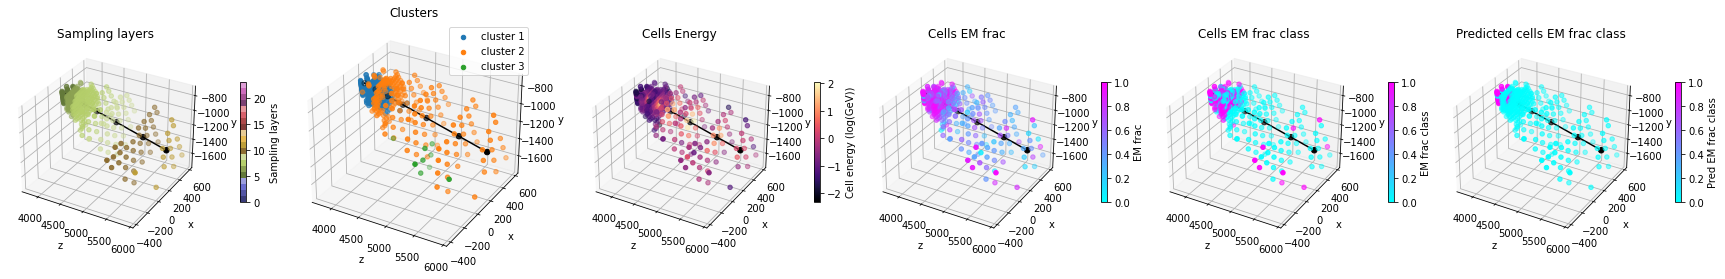

In [139]:
for idx in [11]:#range(26):#x_plot_idxs_dict['quad_2'][:50]:
    plot_event_3d_info(idx)

# idx: 201 separated photons ??
# idxs: [ 947,  472,  218, 1392, 1176, 1186,  543,   78, 1340,  747, 1346,  904,  404 ] high pT

# 2 groups of high em frac cells: event index: [35, 274, 223, 246]

Train analysis

In [145]:
# Q - what % of neutral event cells have em frac >= 0.9963305116161616
neutral_cut_cellwise = []
for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
    for cluster_idx, truth_particle in enumerate(clus_truth_part):
        neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
neutral_cut_cellwise = np.array(neutral_cut_cellwise)

neutral_cells_em_frac = np.array(flatten_events_to_cells(processed_event_data["truth_EM_frac"]))[~neutral_cut_cellwise]
print(len(neutral_cells_em_frac[neutral_cells_em_frac >= 0.948]) / len(neutral_cells_em_frac))

# neutral:
# 43% of cells em frac = 1
# 90% of cells em frac >= 0.9963305116161616
# 80% of cells em frac >= 0.999
# 98% of cells em frac >= 0.948

# charged:
# 7% of cells em frac = 1
# 13% of cells em frac >= 0.9963305116161616
# 10% of cells em frac >= 0.999
# 30% of cells em frac >= 0.948


0.29370263074596986


Classification threshold analysis

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
accuracies: [0.744854805689197, 0.7450456419870682, 0.7451773924311755, 0.7453082253930815, 0.7454311680080562, 0.7455120899382113, 0.7455563125803141, 0.7456073245907066, 0.74566604345159, 0.7457445799280217, 0.7457937569740116, 0.7457777927837089, 0.7457831141804765, 0.7457686179616958, 0.745740543006336, 0.7457023757467617, 0.7456698968768355, 0.7456141139589962, 0.7455304395822373, 0.7454456642268368, 0.7453342818875985, 0.7452331753490148, 0.7450564682770436, 0.7448997623170609, 0.7447395699247132]
thresholds [0.62, 0.6241666666666666, 0.6283333333333333, 0.6325, 0.6366666666666667, 0.6408333333333334, 0.645, 0.6491666666666667, 0.6533333333333333, 0.6575, 0.6616666666666666, 0.6658333333333333, 0.6699999999999999, 0.6741666666666667, 0.6783333333333333, 0.6825, 0.6866666666666666, 0.6908333333333333, 0.695, 0.6991666666666666, 0.7033333333333334, 0.7075, 0.7116666666666667, 0.7158333333333333, 0.72]


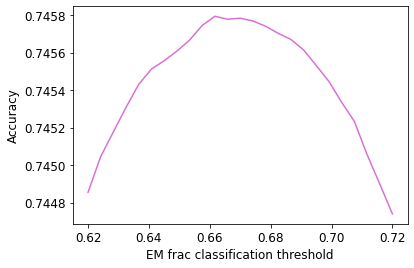

In [374]:
# compute accuracy at different EM frac classification thresholds
threshold_low = 0.62
threshold_high = 0.72
accuracies = []
thresholds = []
for i, threshold in enumerate(np.linspace(threshold_low, threshold_high, 25)):
    print(i)
    labels = np.array([cell_EM_frac > threshold for cell_EM_frac in flatten_events_to_cells(processed_event_data["truth_EM_frac"])])
    thresholds.append(threshold)
    accuracies.append(get_accuracy(preds, labels))

print("accuracies:", accuracies)
print("thresholds", thresholds)

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(thresholds, accuracies, color='orchid')
plt.xlabel("EM frac classification threshold")
plt.ylabel("Accuracy")
plt.show()


In [6]:
print("best threshold:", thresholds[np.argmax(accuracies)])
print("best accuracy:", accuracies[np.argmax(accuracies)])

NameError: name 'thresholds' is not defined

Weighting cells anlaysis

In [323]:
def plot_leading_cells_energy_frac_same_axis(cell_nums, preds, labels, em_frac, num_points):
    fig = plt.figure(figsize=(2*len(cell_nums), 6))
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(1, len(cell_nums), hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)

    for i, cell_num in enumerate(cell_nums):
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        em_frac_cut_cell = np.array([em_frac_clus[cell_num] for em_frac_clus in em_frac if len(em_frac_clus) > cell_num])
        accuracy = []

        for j in range(num_points):
            em_frac_cut = (em_frac_cut_cell >= j*(1/num_points)) & (em_frac_cut_cell < (j+1)*(1/num_points))
            accuracy.append(get_accuracy(preds_cut_cell[em_frac_cut], labels_cut_cell[em_frac_cut]) if len(labels_cut_cell[em_frac_cut]) > 0 else None)
        
        em_frac_cuts = np.arange(1/num_points, 1 + (1/num_points), 1/num_points)
        axs[i].plot(accuracy, em_frac_cuts, color='mediumorchid')
        axs[i].axhline(THRESHOLD_EM_FRAC, linewidth='0.5', color='grey')
        axs[i].set_xlabel(cell_nums[i], fontsize=14, labelpad=-5)
        axs[i].set_xlim((1.1, -0.1))

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    
    fig.supxlabel("Leading cells classification accuracy", fontsize=16)
    axs[0].set_ylabel("EM frac", fontsize=16)
    fig.suptitle("Leading cells classification accuracy vs EM fraction", fontsize=16)

    plt.show()

def plot_leading_cells_energy_frac_same_axis(cell_nums, preds, labels, em_frac, num_points):
    fig = plt.figure(figsize=(7, 2.5*len(cell_nums)))
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(len(cell_nums), 1, hspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)

    cell_nums.reverse()
    for i, cell_num in enumerate(cell_nums):
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        em_frac_cut_cell = np.array([em_frac_clus[cell_num] for em_frac_clus in em_frac if len(em_frac_clus) > cell_num])
        accuracy = []

        for j in range(num_points):
            em_frac_cut = (em_frac_cut_cell >= j*(1/num_points)) & (em_frac_cut_cell < (j+1)*(1/num_points))
            accuracy.append(get_accuracy(preds_cut_cell[em_frac_cut], labels_cut_cell[em_frac_cut]) if len(labels_cut_cell[em_frac_cut]) > 0 else None)
        
        em_frac_cuts = np.arange(1/num_points, 1 + (1/num_points), 1/num_points)
        axs[i].plot(em_frac_cuts, accuracy, color='mediumorchid')
        axs[i].axvline(THRESHOLD_EM_FRAC, linewidth='0.5', color='grey')
        axs[i].set_ylabel(cell_num, fontsize=14, labelpad=-1)
        axs[i].set_yticks([0,1])

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    
    fig.supylabel("Leading cells classification accuracy", fontsize=16)
    axs[-1].set_xlabel("EM frac", fontsize=16)
    axs[0].set_title("Leading cells classification accuracy vs EM fraction", fontsize=16, pad=15)

    plt.show()

def plot_leading_cell_vs_accuracy(preds, labels, cells, ylim=None):
    accuracy = []
    for cell_num in cells:
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        accuracy.append(get_accuracy(preds_cut_cell, labels_cut_cell) if len(labels_cut_cell) > 0 else None)

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(cells, accuracy, color="darkcyan")
    plt.xlabel("Leading cell num")
    plt.ylabel("Accuracy")
    plt.title("Truth EM frac vs classification accuracy")
    plt.ylim(ylim)
    plt.show()


/tmp/ipykernel_19066/3437860974.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  em_frac = np.array([clus_data for event_data in processed_event_data["truth_EM_frac"] for clus_data in event_data])


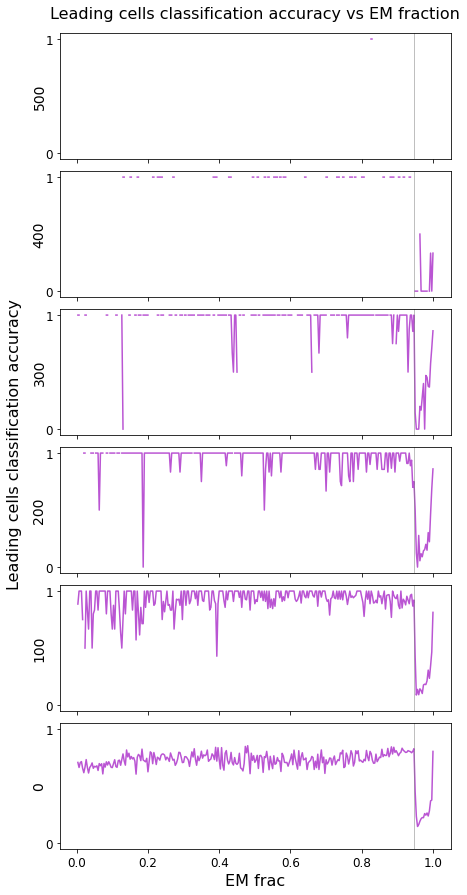

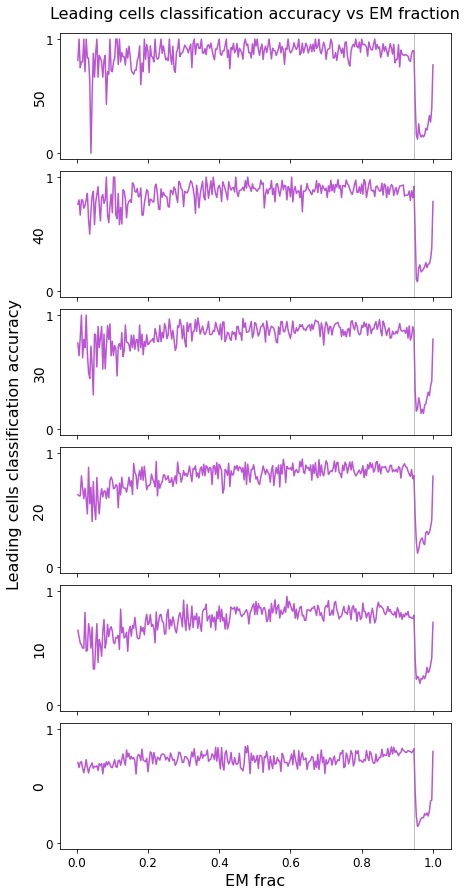

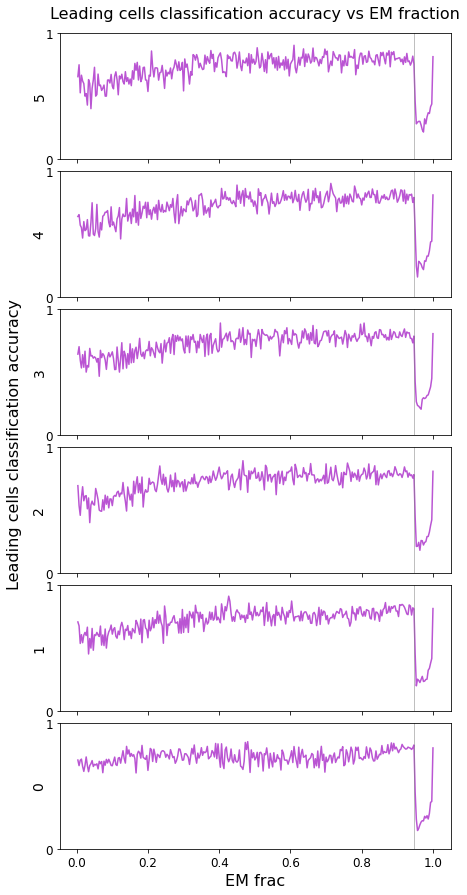

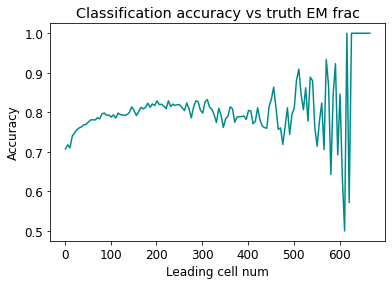

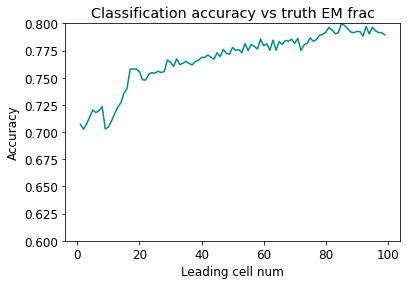

In [449]:
# preprocess preds and lables to be grouped by clusters instead of events
def regroup_by_clus(data):
    reshape_data = []
    for event_idx, event_data in enumerate(data):
        data_event_idx = 0
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_data.append(event_data[data_event_idx:data_event_idx + len(clus_truth_em_class)])
            data_event_idx += len(clus_truth_em_class)
    return reshape_data


def regroup_by_clus_and_event(data):
    reshape_data = []
    for event_idx, event_data in enumerate(data):
        data_event_idx = 0
        reshape_data.append([])
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_data[event_idx].append(event_data[data_event_idx:data_event_idx + len(clus_truth_em_class)])
            data_event_idx += len(clus_truth_em_class)
    return reshape_data


dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'#pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2' #
epoch = 13 # start at 0
preds = regroup_by_clus(np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))
labels = regroup_by_clus(np.expand_dims(np.load(dir + "/tests/labels.npy")[:, :, 0], -1))
em_frac = np.array([clus_data for event_data in processed_event_data["truth_EM_frac"] for clus_data in event_data])
num_points = 300

plot_leading_cells_energy_frac_same_axis([0, 100, 200, 300, 400, 500], preds, labels, em_frac, num_points)
plot_leading_cells_energy_frac_same_axis([0, 10, 20, 30, 40, 50], preds, labels, em_frac, num_points)
plot_leading_cells_energy_frac_same_axis([0, 1, 2, 3, 4, 5], preds, labels, em_frac, num_points)
plot_leading_cell_vs_accuracy(preds, labels, np.arange(1, 1000, 5))
plot_leading_cell_vs_accuracy(preds, labels, np.arange(1, 100, 1), (0.6, 0.80))

Charged event dataset threshold analysis

Cell weighting data analysis

In [ ]:
#counts_all, bins = np.histogram(weights[~neutral_cut], 100)

def plot_hist(data, bins, title, x_label, y_label, normalize=True, colour=None, xlim=None):
    counts, bins = np.histogram(data, bins)
    # normalize counts
    if normalize:
        counts = counts / np.sum(counts)#(counts_all)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(bins[:-1], bins, weights=counts, color=colour)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim)
    plt.show()

In [ ]:
# plot cell weighting distribution
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2'
epoch = 3 # start at 0
weights = np.load(dir + "/tests/labels.npy")[:, :, 1]
weights = weights[weights != -1]
neutral_cut = get_neutral_cell_cut()

plot_hist(weights[neutral_cut], 100, "Neutral cell weights", "Weight", "Frequency", colour="darkseagreen")
plot_hist(weights[~neutral_cut], 100, "Charged cell weights", "Weight", "Frequency", colour="darkseagreen")
plot_hist(weights[(weights >= 0.01) & (weights <= 0.2)], 100, "All cell weights", "Weight", "Frequency", colour="darkseagreen")

print("neutral (num cells weight 1):", len(weights[neutral_cut][(weights[neutral_cut] >= 0.7) & (weights[neutral_cut] >= 0.7)]) / len(weights[neutral_cut]))
print("charged (num cells weight 1):", len(weights[~neutral_cut][(weights[~neutral_cut] >= 0.7) & (weights[~neutral_cut] >= 0.7)]) / len(weights[~neutral_cut]))

In [ ]:
# plot num clustes in events
num_clus = np.array([len(clusters_E) for clusters_E in processed_event_data["cluster_E"]])
pu.plot_hist(num_clus, np.max(num_clus) - 1, "Number of cluster per event", "Number of clusters", "frequency", True, "darkseagreen")

neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])
pu.plot_hist(num_clus[neutral_cut], np.max(num_clus[neutral_cut]) - 1, "Number of cluster per neutral pion event", "Number of clusters", "frequency", True, "darkseagreen")
pu.plot_hist(num_clus[~neutral_cut], np.max(num_clus[~neutral_cut]) - 1, "Number of cluster per charged pion event", "Number of clusters", "frequency", True, "darkseagreen")

print("neutral less than 5 clus:", len(num_clus[neutral_cut][num_clus[neutral_cut] <= 3]) / len(num_clus[neutral_cut]))
print("charged less than 5 clus:", len(num_clus[~neutral_cut][num_clus[~neutral_cut] <= 3]) / len(num_clus[~neutral_cut]))
print("mean num clus neutral", np.mean(num_clus[neutral_cut]), "charged:", np.mean(num_clus[~neutral_cut]))


# plot num cells in events
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2'#pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'
labels_unmasked = np.expand_dims(np.load(dir + "/tests/labels.npy")[:,:,0], -1)
num_cells = np.array([len(event_labels[event_labels != -1]) for event_labels in labels_unmasked])

pu.plot_hist(num_cells, 100, "Number of cells", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells[neutral_cut], 100, "Number of cells per neutral pion event", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells[~neutral_cut], 100, "Number of cells per charged pion event", "Number of cells", "frequency", True, "darkseagreen")
print("neutral 1 cell:", len(num_cells[neutral_cut][num_cells[neutral_cut] == 1]) / len(num_cells[neutral_cut]))
print("charged 1 cell:", len(num_cells[~neutral_cut][num_cells[~neutral_cut] == 1]) / len(num_cells[~neutral_cut]))
print("mean num cells neutral", np.mean(num_cells[neutral_cut]), "charged:", np.mean(num_cells[~neutral_cut]))


# plot num cells per cluster in events
num_cells_per_clus = np.array([len(clus) for event in processed_event_data["cluster_cell_E"] for clus in event])
neutral_cut_cluswise = np.array([clus_truth_part == 0 for event_truth_part in processed_event_data["truth_particle"] for clus_truth_part in event_truth_part])

pu.plot_hist(num_cells_per_clus, 100, "Number of cells per cluster", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells_per_clus[neutral_cut_cluswise], 100, "Number of cells per neutral pion cluster", "analNumber of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells_per_clus[~neutral_cut_cluswise], 100, "Number of cells per charged pion cluster", "Number of cells", "frequency", True, "darkseagreen")
print("neutral less than 10 cells:", len(num_cells_per_clus[neutral_cut_cluswise][(num_cells_per_clus[neutral_cut_cluswise] <= 10) & (num_cells_per_clus[neutral_cut_cluswise] >= 5)]) / len(num_cells_per_clus[neutral_cut_cluswise]))
print("charged less than 10 cells:", len(num_cells_per_clus[~neutral_cut_cluswise][(num_cells_per_clus[~neutral_cut_cluswise] <= 10) & (num_cells_per_clus[~neutral_cut_cluswise] >= 5)]) / len(num_cells_per_clus[~neutral_cut_cluswise]))


Classification threshold analysis

In [5]:
# plot hist of cellwise truth EM frac
truth_EM_frac_cellwise = flatten_events_to_cells(processed_event_data["truth_EM_frac"])
pu.plot_hist(truth_EM_frac_cellwise, 50, "Truth EM frac per cell", "EM frac", "frequency")

# split array into N equal parts
num_class = 2
truth_EM_frac_cellwise_sort = np.sort(truth_EM_frac_cellwise)
truth_EM_frac_cellwise_split = np.array_split(truth_EM_frac_cellwise_sort, num_class)
print(np.max(truth_EM_frac_cellwise_split[0]))

labels = np.arange(num_class)
fig = plt.figure()
fig.patch.set_facecolor('white')
for i, data in enumerate(truth_EM_frac_cellwise_split):
    bins = math.ceil((np.max(data) - np.min(data))*50)
    counts, bins = np.histogram(data, bins, density=False)
    # normalize counts
    plt.stairs(counts, bins, label=str(np.round(np.min(data), 4)) + " - " + str(np.round(np.max(data), 4)))

plt.title("Charged events cells em frac")
plt.xlabel("EM frac")
plt.ylabel("frequency")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()


NameError: name 'flatten_events_to_cells' is not defined

Visualize Pointnet++

In [232]:
sys.path.append('/home/jbohm/start_tf/atlas-pointnet')
from model.pointnet2_utils import *
import torch

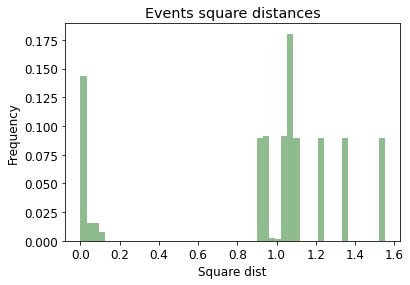

/tmp/ipykernel_22601/2228881842.py:62: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


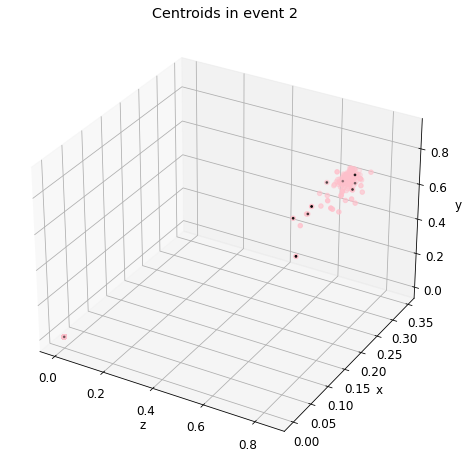

/tmp/ipykernel_22601/2228881842.py:74: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


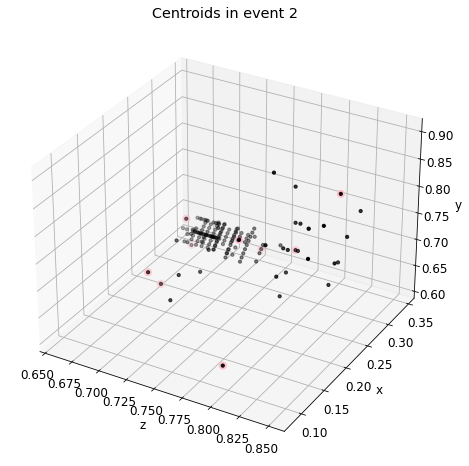

/tmp/ipykernel_22601/2228881842.py:92: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


centroid 0
(x,y,z): (0.0, 0.0, 0.0)
x: 0.0 -> 0.0
y: 0.0 -> 0.0
z: 0.0 -> 0.0


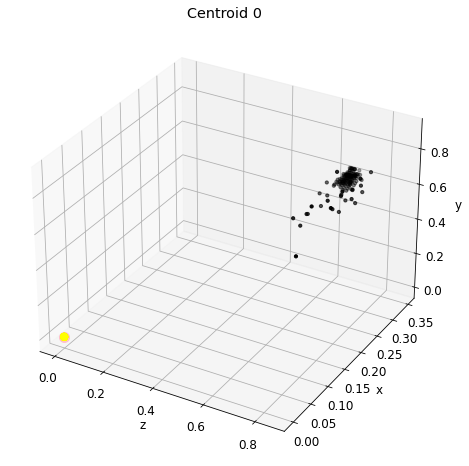

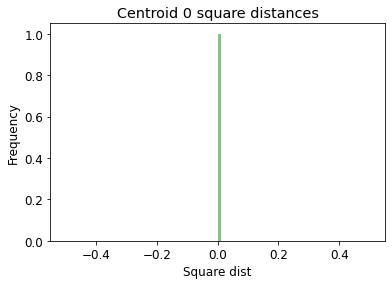

centroid 1
(x,y,z): (0.21414317548176365, 0.885433241207167, 0.8496313769028789)
x: 0.12911571538454908 -> 0.2642502445446084
y: 0.7932335274428606 -> 0.9020467548822738
z: 0.7972239592137977 -> 0.8496313769028789


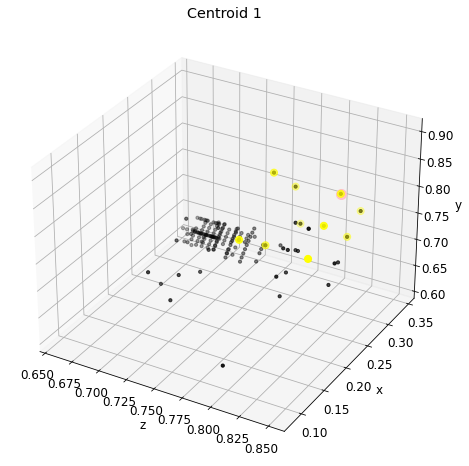

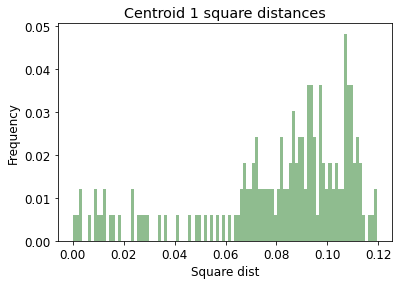

centroid 2
(x,y,z): (0.3198285110734539, 0.6080836166154595, 0.672222482980616)
x: 0.3198285110734539 -> 0.33134333362779234
y: 0.6080836166154595 -> 0.6252027912423943
z: 0.6688824866949343 -> 0.6776541179585183


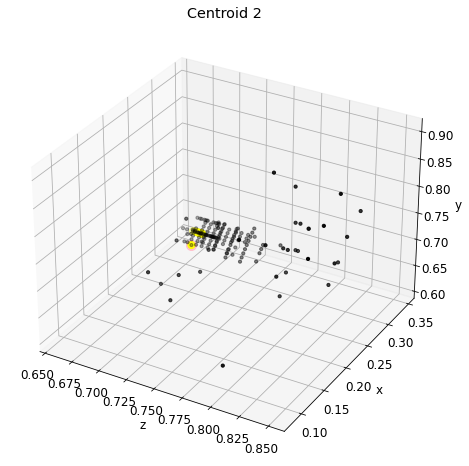

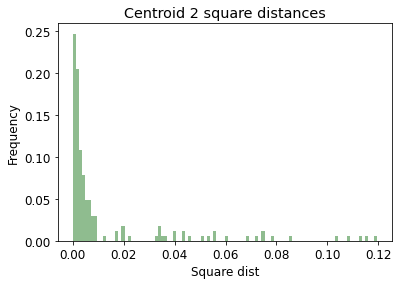

centroid 3
(x,y,z): (0.08258901639202978, 0.6493520173852902, 0.8026559075015031)
x: 0.08258901639202978 -> 0.2286460611350748
y: 0.6444442757439758 -> 0.7357496544595457
z: 0.6983139303885233 -> 0.8356646225435728


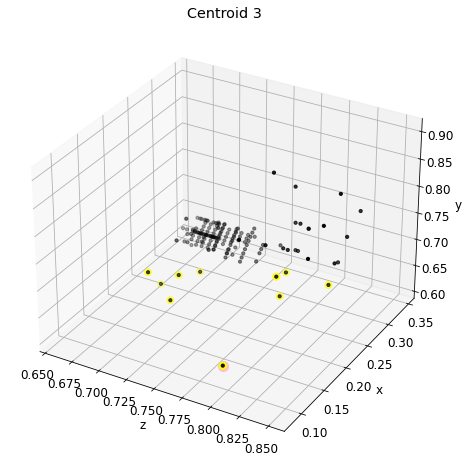

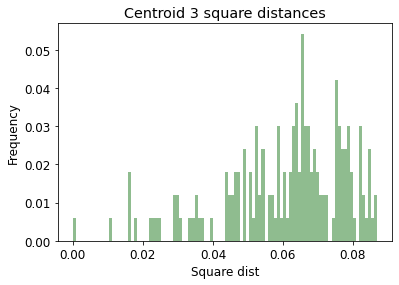

centroid 4
(x,y,z): (0.24967864805075324, 0.7268779941901803, 0.798093275685136)
x: 0.20676643889185742 -> 0.2706216516510532
y: 0.7012497259646046 -> 0.7870010401225525
z: 0.798093275685136 -> 0.8356646225435728


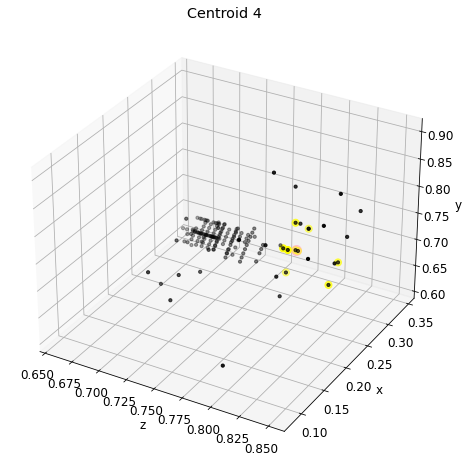

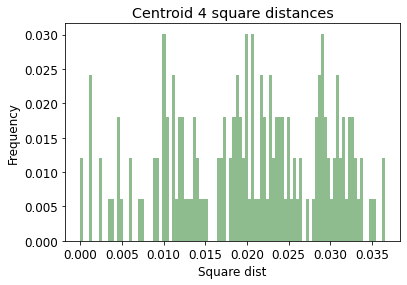

centroid 5
(x,y,z): (0.19459819004671125, 0.6444442757439758, 0.6983139303885233)
x: 0.14281021345404715 -> 0.28374325078426643
y: 0.642681309089303 -> 0.7140913309474972
z: 0.685188480696898 -> 0.7280508567567402


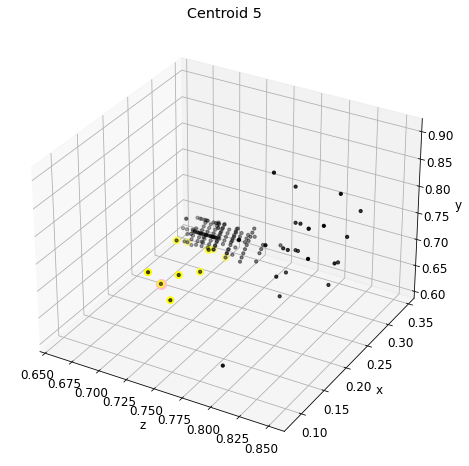

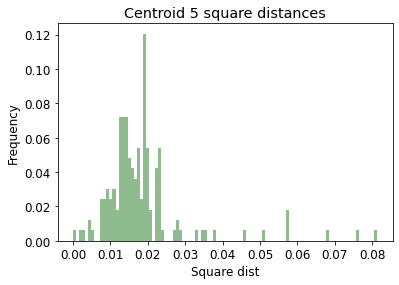

centroid 6
(x,y,z): (0.12911571538454908, 0.8361498269335184, 0.7972239592137977)
x: 0.12911571538454908 -> 0.23591097849084736
y: 0.7601225611523115 -> 0.9020467548822738
z: 0.7972239592137977 -> 0.8496313769028789


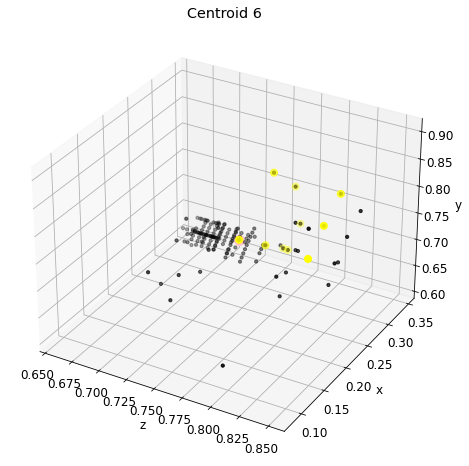

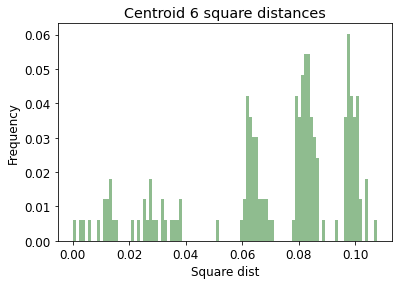

centroid 7
(x,y,z): (0.24967864805075324, 0.7268779941901803, 0.6983139303885233)
x: 0.2102268258971663 -> 0.30797749018051057
y: 0.6641625700507188 -> 0.7268779941901803
z: 0.685188499693025 -> 0.7280508567567402


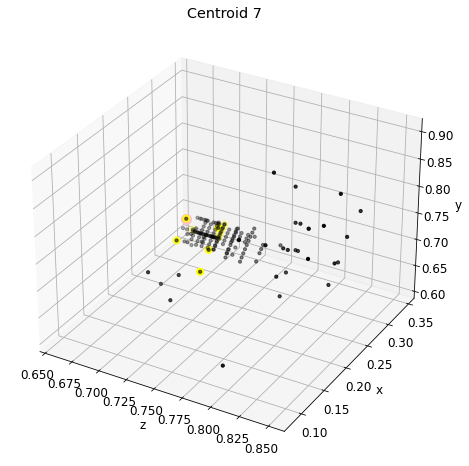

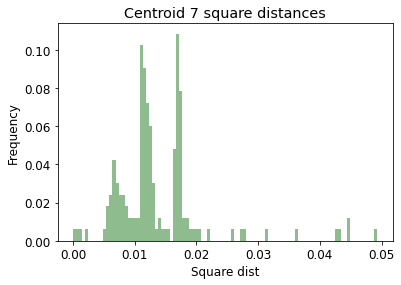

centroid 8
(x,y,z): (0.297878309566542, 0.6620910610865968, 0.7478174659642136)
x: 0.28646074601187604 -> 0.306663517391754
y: 0.6467945500756257 -> 0.6728580598994243
z: 0.7348255836112411 -> 0.7620936293724283


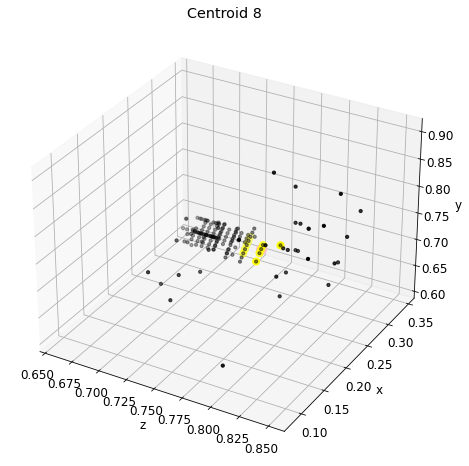

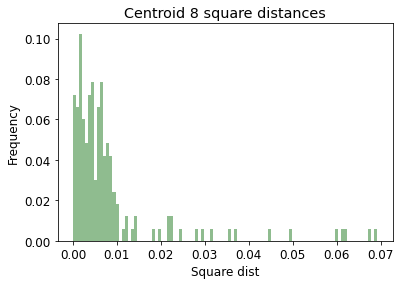

centroid 9
(x,y,z): (0.14281021345404715, 0.7140913309474972, 0.7102435401843897)
x: 0.14281021345404715 -> 0.24967864805075324
y: 0.6444442757439758 -> 0.7357496544595457
z: 0.6983139303885233 -> 0.8080524940394018


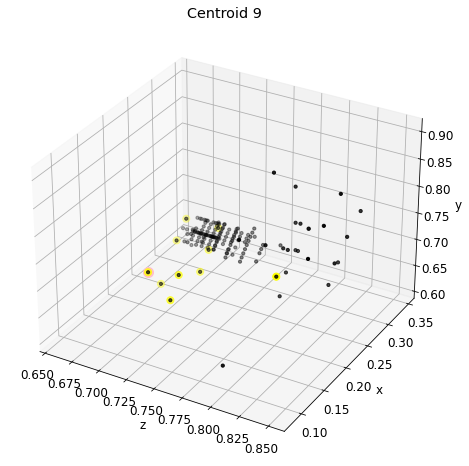

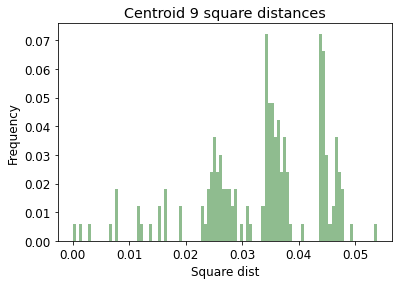

In [234]:
# visualize centroids - run on BS = 1 => one event
event_idx = 2
npoint = 10
radius = 1
nsample = 10
normalize_coords = True
isolate_padding = False

if isolate_padding:
    points = np.full((1, 1615, 4), -100.0)
else:
    points = np.zeros((1, 1615, 4))

event_idxs = [event_idx]
if isolate_padding:
    points = np.full((len(event_idxs), 1615, 4), -100.0)
else:
    points = np.zeros((len(event_idxs), 1615, 4))

for idx, event_idx in enumerate(event_idxs):
    x = flatten_events_to_clus(processed_event_data["x"][event_idx])
    points[idx,:len(x),0] = x
    y = flatten_events_to_clus(processed_event_data["y"][event_idx])
    points[idx,:len(y),1] = y
    z = flatten_events_to_clus(processed_event_data["z"][event_idx])
    points[idx,:len(z),2] = z
    E = flatten_events_to_clus(processed_event_data["cluster_cell_E"][event_idx])
    points[idx,:len(E),3] = E


# normalize with precomputed min and max of dataset
coord_min = {
    'x': -3626,
    'y': -3626,
    'z': -5906,
}
coord_max = {
    'x': 3626,
    'y': 3626,
    'z': 5906,
}

# normalize x
if normalize_coords:
    for coord_idx, coord in enumerate(['x', 'y', 'z']):
        points[:, :len(x), coord_idx] = (points[:, :len(x), coord_idx] - coord_min[coord]) / (coord_max[coord] - coord_min[coord])


xyz = points[:, :, :3]
xyz = torch.from_numpy(xyz)
points = torch.from_numpy(points)



new_xyz, new_points = sample_and_group(npoint, radius, nsample, xyz, points)
sqrdists = square_distance(new_xyz, xyz)

pu.plot_hist(sqrdists, 50, "Events square distances", "Square dist", "Frequency", True, "darkseagreen")

# plot old xyz and new_xyz on same axis - new_xyz is centroids highlighted
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.scatter(xyz[0, :, 2], xyz[0, :, 0], xyz[0, :, 1], color="pink")
ax.scatter(new_xyz[0, :, 2], new_xyz[0, :, 0], new_xyz[0, :, 1], color="black", s=3)
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
plt.title("Centroids in event " + str(event_idx))
plt.show()


# plot old xyz and new_xyz on same axis - new_xyz is centroids highlighted - no pad
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.scatter(xyz[0, :len(x), 2], xyz[0, :len(x), 0], xyz[0, :len(x), 1], color="black", s=10)
ax.scatter(new_xyz[0, 1:, 2], new_xyz[0, 1:, 0], new_xyz[0, 1:, 1], color="pink", s=50)
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
plt.title("Centroids in event " + str(event_idx))
plt.show()


for centroid_idx, grouping in enumerate(np.squeeze(new_points)):
    print("centroid", centroid_idx)
    print("(x,y,z): (" + str(new_xyz[0, centroid_idx, 0].item()) + ", "+ str(new_xyz[0, centroid_idx, 1].item()) + ", " + str(new_xyz[0, centroid_idx, 2].item()) + ")")
    print("x:", min(grouping[:, 0]).item(), "->", max(grouping[:, 0]).item())
    print("y:", min(grouping[:, 1]).item(), "->", max(grouping[:, 1]).item())
    print("z:", min(grouping[:, 2]).item(), "->", max(grouping[:, 2]).item())

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')

    ax.scatter(xyz[0, :len(x), 2], xyz[0, :len(x), 0], xyz[0, :len(x), 1], color="black", s=10)
    ax.scatter([new_xyz[0, centroid_idx, 2]], [new_xyz[0, centroid_idx, 0]], [new_xyz[0, centroid_idx, 1]], color="pink", s=100)
    ax.scatter(grouping[:len(x), 2], grouping[:len(x), 0], grouping[:len(x), 1], color="yellow", s=50)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    plt.title("Centroid " + str(centroid_idx))
    plt.show()

    # plot square dist from centroid distribution
    pu.plot_hist(sqrdists[0, centroid_idx][sqrdists[0, centroid_idx] < 0.3], 100, "Centroid " + str(centroid_idx) + " square distances", "Square dist", "Frequency", True, "darkseagreen")


# iterate through 512 groupings around the centroids and plot in different colous => see how much they overlap ??

# plot the distrbution of square dist for an event